# Extended Kalman Filter :  X and Y as input

### Importing necessary modules

In [79]:
import math
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt

### Importing csv files and reading the data

In [80]:
true_odo = genfromtxt('true_odometry.csv', delimiter=',')
sen_odo = genfromtxt('sensor_odom.csv',delimiter=',')

### Splitting the data into individual arrays

In [81]:
sen_pos_x, sen_pos_y = sen_odo[1:,1], sen_odo[1:,2]
sen_pos_theta = sen_odo[1:,3]

true_x, true_y, true_theta = true_odo[1:,1], true_odo[1:,2], true_odo[1:,3]
v, w = true_odo[1:,4], true_odo[1:,5]
time = sen_odo[1:,0]

### Observation that we are making - x and y position

In [82]:
z = np.c_[sen_pos_x, sen_pos_y]

### Defining Prediction Function

In [83]:
def Prediction(x_t, P_t, F_t, B_t, U_t, G_t, Q_t):
    x_t = F_t.dot(x_t) + B_t.dot(U_t) 
    P_t = (G_t.dot(P_t).dot(G_t.T)) + Q_t

    return x_t, P_t

### Defining Update Function

In [84]:
def Update(x_t, P_t, Z_t, R_t, H_t):
    S = np.linalg.inv( (H_t.dot(P_t).dot(H_t.T)) + R_t )
    K = P_t.dot(H_t.T).dot(S)

    x_t = x_t + K.dot( Z_t - H_t.dot(x_t) )
    P_t = P_t - K.dot(H_t).dot(P_t)

    return x_t, P_t

### Defining various Matrix that will be used in the Filter

In [85]:
# Transition Matrix
F_t = np.array([  [1, 0, 0],
                  [0, 1, 0],
                  [0, 0, 1]  ])


# Initial Covariance State
P_t = 0.005 * np.identity(3)

# Process Covariance
Q_t = 0.044 * np.identity(3)

# Measurement Covariance
R_t = np.array([    [0.24, 0],
                    [0, 0.24]  ])

# Measurement Matrix
H_t = np.array([    [1, 0, 0],
                    [0, 1, 0]   ])

# Initial State
x_t = np.array([ [sen_pos_x[0]], [sen_pos_y[0]], [sen_pos_theta[0]] ])

### Defining empty lists which will be used for plotting purposes later

In [86]:
kal_x, kal_y, kal_theta = [], [], []

## Kalman Filter _ main loop

In [87]:
for i in range(2113):
    if i > 0:
        dt = time[i] - time[i-1]
    else:
        dt = 0

    # Jacobian Matrix - G
    G_t = np.array([    [1, 0, -v[i]*(math.sin(sen_pos_theta[i]))*dt],
                        [0, 1, v[i]*(math.cos(sen_pos_theta[i]))*dt],
                        [0, 0, 1]                                      ])
    # Input Transition Matrix - B
    B_t = np.array([    [dt * (math.cos(sen_pos_theta[i])), 0],
                        [dt * (math.sin(sen_pos_theta[i])), 0],
                        [0, dt]                                    ])
    # Input to the system - v and w ( velocity and turning rate )
    U_t = np.array([    [v[i]],
                        [w[i]]     ])

    # Prediction Step
    x_t, P_t = Prediction(x_t, P_t, F_t, B_t, U_t, G_t, Q_t)

    # Reshaping the measurement data
    Z_t = z[i].transpose()
    Z_t = Z_t.reshape(Z_t.shape[0], -1)

    # Update Step
    x_t, P_t = Update(x_t, P_t, Z_t, R_t, H_t)
    
    kal_x.append(x_t[0])
    kal_y.append(x_t[1])
    kal_theta.append(x_t[2])

In [88]:
print('*'*50)
print('\n'," Final Filter State Matrix : \n", x_t,'\n')
print('*'*50)

**************************************************

  Final Filter State Matrix : 
 [[-1.99083827]
 [-0.33128117]
 [ 6.2475753 ]] 

**************************************************


## Plotting

### For Plotting Purposes

In [89]:
kal_x = np.concatenate(kal_x).ravel()
kal_y = np.concatenate(kal_y).ravel()
kal_theta = np.concatenate(kal_theta).ravel()

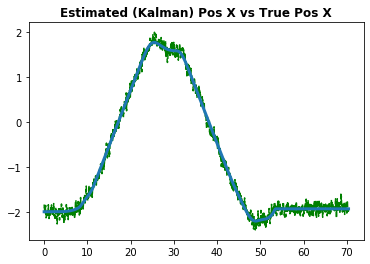

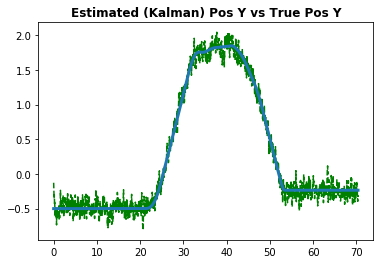

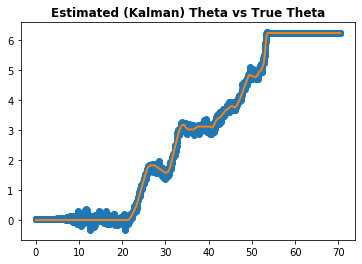

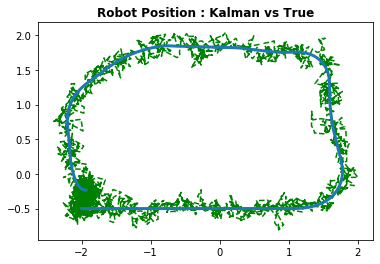

In [90]:
plt.figure(1)
plt.title('Estimated (Kalman) Pos X vs True Pos X', fontweight='bold') 
plt.plot(time,kal_x[:],'g--')
plt.plot(time,true_x, linewidth=3)


plt.figure(2)
plt.title('Estimated (Kalman) Pos Y vs True Pos Y', fontweight='bold') 
plt.plot(time,kal_y[:],'g--')
plt.plot(time,true_y, linewidth=3)

plt.figure(3)
plt.title('Estimated (Kalman) Theta vs True Theta', fontweight='bold') 
plt.plot(time,kal_theta[:],'o--')
plt.plot(time,true_theta, linewidth=2)


plt.figure(4)
plt.title('Robot Position : Kalman vs True', fontweight='bold')
plt.plot(kal_x,kal_y,'g--')
plt.plot(true_x,true_y, linewidth=3)


plt.show()

### Statistically Comparing True and Filtered (Estimated) Data 

In [91]:
std_k_x = np.std(kal_x)
std_true_x = np.std(true_x)

print('*'*10)
print(" X co-ordinate")
print(' Standard Deviation Kalman : ', std_k_x)
print(' Standard Deviation True : ', std_true_x)

mean_k_x = np.mean(kal_x)
mean_true_x = np.mean(true_x)

print(' Mean Kalman : ', mean_k_x)
print(' Mean True : ', mean_true_x, '\n')

std_k_y = np.std(kal_y)
std_true_y = np.std(true_y)

print('*'*10)
print(" Y co-ordinate ")
print(' Standard Deviation Kalman : ', std_k_y)
print(' Standard Deviation True : ', std_true_y)

mean_k_y = np.mean(kal_y)
mean_true_y = np.mean(true_y)

print(' Mean Kalman : ', mean_k_y)
print(' Mean True : ', mean_true_y, '\n')

std_k_theta = np.std(kal_theta)
std_true_theta = np.std(true_theta)

print('*'*10)
print(" Theta ")
print(' Standard Deviation Kalman : ', std_k_theta)
print(' Standard Deviation True : ', std_true_theta)

mean_k_theta = np.mean(kal_theta)
mean_true_theta = np.mean(true_theta)

print(' Mean Kalman : ', mean_k_theta)
print(' Mean True : ', mean_true_theta, '\n')

**********
 X co-ordinate
 Standard Deviation Kalman :  1.398293055060191
 Standard Deviation True :  1.394499332823286
 Mean Kalman :  -0.8286784316163939
 Mean True :  -0.8274896613354472 

**********
 Y co-ordinate 
 Standard Deviation Kalman :  0.8877492916430367
 Standard Deviation True :  0.8858276648586231
 Mean Kalman :  0.25793868762067707
 Mean True :  0.2572428752003786 

**********
 Theta 
 Standard Deviation Kalman :  2.4629848910087904
 Standard Deviation True :  2.4605359734116723
 Mean Kalman :  2.84663444931528
 Mean True :  2.8364238206963086 

